# Customer Clustering Model

Este notebook implementa un modelo de clustering para segmentar clientes basado en sus patrones de compra y características demográficas.

## Objetivos:
1. Preparar los datos para clustering
2. Determinar el número óptimo de clusters
3. Implementar algoritmos de clustering (K-Means, Hierarchical)
4. Analizar y interpretar los clusters
5. Visualizar los resultados

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Load the cleaned data
data = pd.read_csv('../data/marketing_campaign_cleaned.csv')

print(f"Dataset shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
data.head()

Dataset shape: (2240, 33)
Columns: ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Total_MntSpent', 'Total_Purchases', 'Children', 'Customer_Since']


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Total_MntSpent,Total_Purchases,Children,Customer_Since
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,3,11,1,1617,25,0,4482
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,3,11,0,27,6,2,3932
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,3,11,0,776,21,0,4131
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,3,11,0,53,8,1,3958
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,3,11,0,422,19,1,3980


## Data Preparation for Clustering

In [4]:
# Select relevant features for clustering
# We'll focus on customer behavior and demographics
clustering_features = [
    'Year_Birth', 'Income', 'Recency', 'Children',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
    'MntSweetProducts', 'MntGoldProds',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'NumWebVisitsMonth', 'Total_MntSpent', 'Total_Purchases', 'Customer_Since'
]

# Check if all features exist in the dataset
available_features = [col for col in clustering_features if col in data.columns]
missing_features = [col for col in clustering_features if col not in data.columns]

print(f"Available features: {len(available_features)}")
print(f"Available features: {available_features}")
if missing_features:
    print(f"Missing features: {missing_features}")

# Create clustering dataset
clustering_data = data[available_features].copy()

# Handle any remaining missing values
print(f"\nMissing values per column:")
print(clustering_data.isnull().sum())

# Fill missing values if any
clustering_data = clustering_data.fillna(clustering_data.median())

print(f"\nClustering dataset shape: {clustering_data.shape}")
clustering_data.describe()

Available features: 18
Available features: ['Year_Birth', 'Income', 'Recency', 'Children', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Total_MntSpent', 'Total_Purchases', 'Customer_Since']

Missing values per column:
Year_Birth             0
Income                 0
Recency                0
Children               0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
Total_MntSpent         0
Total_Purchases        0
Customer_Since         0
dtype: int64

Clustering dataset shape: (2240, 18)


,Year_Birth,Income,Recency,Children,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Total_MntSpent,Total_Purchases,Customer_Since
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1968.805804,52237.975446,49.109375,0.950446,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,605.798214,14.862054,4172.582143
std,11.984069,25037.955891,28.962453,0.751803,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,602.249288,7.677173,202.122512
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,3819.000000
25%,1959.000000,35538.750000,24.000000,0.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,68.750000,8.000000,3999.750000
50%,1970.000000,51381.500000,49.000000,1.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,396.000000,15.000000,4174.500000
75%,1977.000000,68289.750000,74.000000,1.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,1045.500000,21.000000,4348.000000
max,1996.000000,666666.000000,99.000000,3.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,2525.000000,44.000000,4518.000000


In [5]:
# Feature Engineering for better clustering
# Create additional meaningful features

# Age from birth year
if 'Year_Birth' in clustering_data.columns:
    clustering_data['Age'] = 2024 - clustering_data['Year_Birth']
    clustering_data = clustering_data.drop('Year_Birth', axis=1)

# Average spending per category
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
available_spending = [col for col in spending_columns if col in clustering_data.columns]

if len(available_spending) > 1:
    clustering_data['Avg_Category_Spending'] = clustering_data[available_spending].mean(axis=1)

# Purchase frequency (purchases per day since customer)
if 'Total_Purchases' in clustering_data.columns and 'Customer_Since' in clustering_data.columns:
    clustering_data['Purchase_Frequency'] = clustering_data['Total_Purchases'] / (clustering_data['Customer_Since'] + 1)

# Spending per purchase
if 'Total_MntSpent' in clustering_data.columns and 'Total_Purchases' in clustering_data.columns:
    clustering_data['Avg_Spending_Per_Purchase'] = clustering_data['Total_MntSpent'] / (clustering_data['Total_Purchases'] + 1)

print(f"Enhanced clustering dataset shape: {clustering_data.shape}")
print(f"New features added:")
new_features = [col for col in clustering_data.columns if col not in available_features]
print(new_features)

clustering_data.head()

Enhanced clustering dataset shape: (2240, 21)
New features added:
['Age', 'Avg_Category_Spending', 'Purchase_Frequency', 'Avg_Spending_Per_Purchase']


,Income,Recency,Children,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Total_MntSpent,Total_Purchases,Customer_Since,Age,Avg_Category_Spending,Purchase_Frequency,Avg_Spending_Per_Purchase
0,58138.0,58,0,635,88,546,172,88,88,3,...,10,4,7,1617,25,4482,67,269.500000,0.005577,62.192308
1,46344.0,38,2,11,1,6,2,1,6,2,...,1,2,5,27,6,3932,70,4.500000,0.001526,3.857143
2,71613.0,26,0,426,49,127,111,21,42,1,...,2,10,4,776,21,4131,59,129.333333,0.005082,35.272727
3,26646.0,26,1,11,4,20,10,3,5,2,...,0,4,6,53,8,3958,40,8.833333,0.002021,5.888889
4,58293.0,94,1,173,43,118,46,27,15,5,...,3,6,5,422,19,3980,43,70.333333,0.004773,21.100000


In [6]:
# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)
scaled_df = pd.DataFrame(scaled_data, columns=clustering_data.columns, index=clustering_data.index)

print(f"Standardized data shape: {scaled_df.shape}")
print(f"Mean of scaled features (should be ~0): {scaled_df.mean().round(3).tolist()}")
print(f"Std of scaled features (should be ~1): {scaled_df.std().round(3).tolist()}")

scaled_df.head()

Standardized data shape: (2240, 21)
Mean of scaled features (should be ~0): [-0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0]
Std of scaled features (should be ~1): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


,Income,Recency,Children,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Total_MntSpent,Total_Purchases,Customer_Since,Age,Avg_Category_Spending,Purchase_Frequency,Avg_Spending_Per_Purchase
0,0.235696,0.307039,-1.264505,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,...,2.510890,-0.550785,0.693904,1.679417,1.320826,1.531185,0.985345,1.679417,1.120049,0.976611
1,-0.235454,-0.383664,1.396361,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,...,-0.568720,-1.166125,-0.130463,-0.961275,-1.154596,-1.190545,1.235733,-0.961275,-1.119753,-0.845726
2,0.773999,-0.798086,-1.264505,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,...,-0.226541,1.295237,-0.542647,0.282673,0.799685,-0.205773,0.317643,0.282673,0.846733,0.135668
3,-1.022355,-0.798086,0.065928,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,...,-0.910898,-0.550785,0.281720,-0.918094,-0.894025,-1.061881,-1.268149,-0.918094,-0.845983,-0.782256
4,0.241888,1.550305,0.065928,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,...,0.115638,0.064556,-0.130463,-0.305254,0.539114,-0.953012,-1.017761,-0.305254,0.675550,-0.307075


## Determining Optimal Number of Clusters

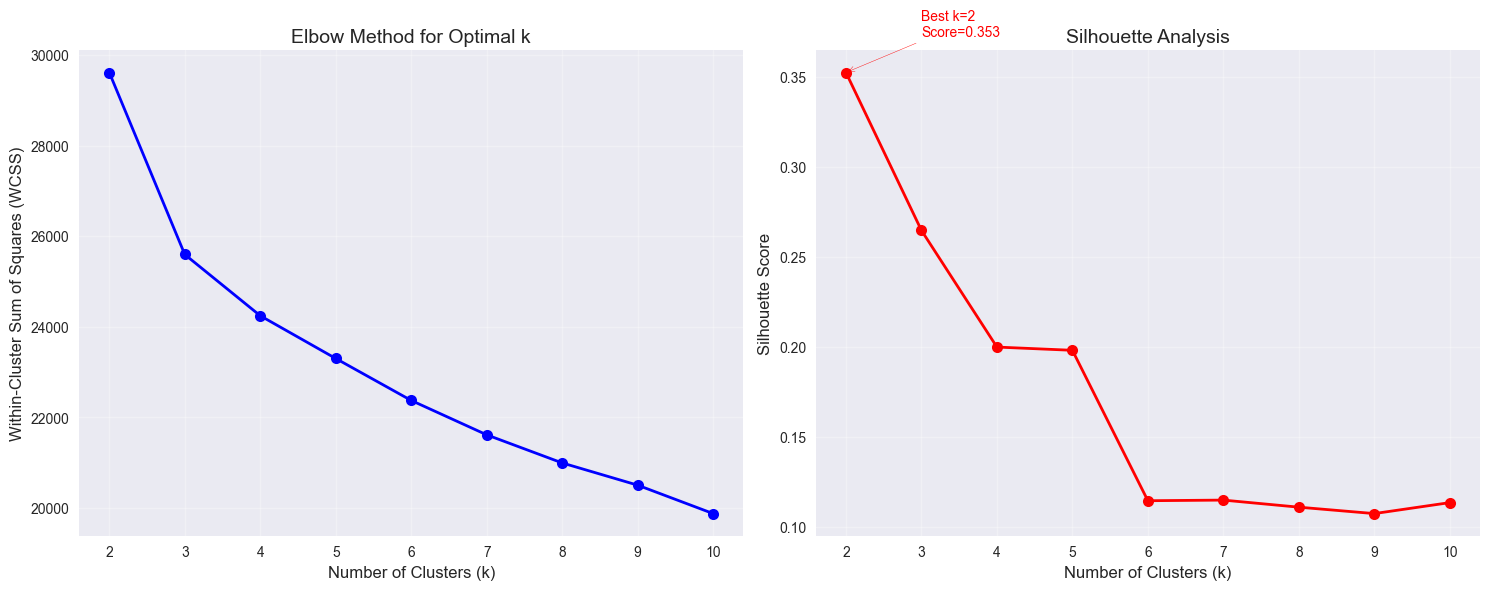


Silhouette Scores by number of clusters:
k=2: 0.3526
k=3: 0.2648
k=4: 0.1999
k=5: 0.1981
k=6: 0.1145
k=7: 0.1148
k=8: 0.1109
k=9: 0.1073
k=10: 0.1134

Recommended number of clusters based on silhouette score: 2


In [7]:
# Elbow Method for K-Means
def elbow_method(data, max_clusters=10):
    """
    Perform elbow method to find optimal number of clusters
    """
    inertias = []
    silhouette_scores = []
    K_range = range(2, max_clusters + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    return K_range, inertias, silhouette_scores

# Calculate metrics
k_range, inertias, silhouette_scores = elbow_method(scaled_df, max_clusters=10)

# Plot Elbow Method and Silhouette Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow plot
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontsize=14)
ax1.grid(True, alpha=0.3)

# Silhouette score plot
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Analysis', fontsize=14)
ax2.grid(True, alpha=0.3)

# Mark the best silhouette score
best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
ax2.annotate(f'Best k={best_k}\nScore={best_score:.3f}', 
             xy=(best_k, best_score), 
             xytext=(best_k+1, best_score+0.02),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, color='red')

plt.tight_layout()
plt.show()

print(f"\nSilhouette Scores by number of clusters:")
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")

print(f"\nRecommended number of clusters based on silhouette score: {best_k}")

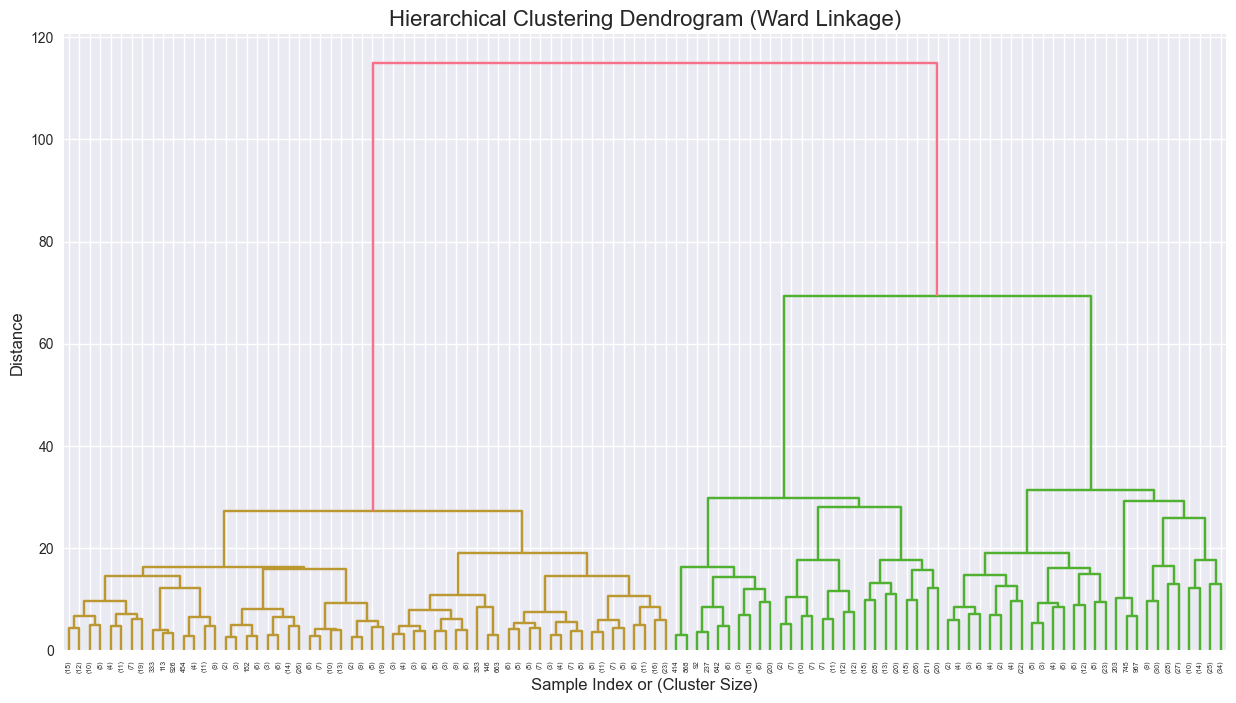

Dendrogram based on 1000 samples


In [8]:
# Hierarchical Clustering Dendrogram
# Sample data for dendrogram (use subset if data is large)
sample_size = min(1000, len(scaled_df))
sample_indices = np.random.choice(len(scaled_df), sample_size, replace=False)
sample_data = scaled_df.iloc[sample_indices]

# Calculate linkage matrix
linkage_matrix = linkage(sample_data, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=6)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=16)
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.show()

print(f"Dendrogram based on {sample_size} samples")

## K-Means Clustering Implementation

In [9]:
# Implement K-Means with optimal number of clusters
optimal_k = best_k  # From silhouette analysis

# Fit K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_df)

# Calculate clustering metrics
kmeans_silhouette = silhouette_score(scaled_df, kmeans_labels)
kmeans_inertia = kmeans.inertia_

print(f"K-Means Results (k={optimal_k}):")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Inertia (WCSS): {kmeans_inertia:.2f}")
print(f"\nCluster Distribution:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} customers ({count/len(kmeans_labels)*100:.1f}%)")

# Add cluster labels to original data
data_with_clusters = data.copy()
data_with_clusters['KMeans_Cluster'] = kmeans_labels
clustering_data['KMeans_Cluster'] = kmeans_labels

K-Means Results (k=2):
Silhouette Score: 0.3526
Inertia (WCSS): 29613.01

Cluster Distribution:
Cluster 0: 956 customers (42.7%)
Cluster 1: 1284 customers (57.3%)


## Hierarchical Clustering Implementation

In [10]:
# Implement Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(scaled_df)

# Calculate clustering metrics
hierarchical_silhouette = silhouette_score(scaled_df, hierarchical_labels)

print(f"Hierarchical Clustering Results (k={optimal_k}):")
print(f"Silhouette Score: {hierarchical_silhouette:.4f}")
print(f"\nCluster Distribution:")
unique, counts = np.unique(hierarchical_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} customers ({count/len(hierarchical_labels)*100:.1f}%)")

# Add cluster labels to data
data_with_clusters['Hierarchical_Cluster'] = hierarchical_labels
clustering_data['Hierarchical_Cluster'] = hierarchical_labels

# Compare clustering methods
print(f"\n=== Clustering Method Comparison ===")
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Hierarchical Silhouette Score: {hierarchical_silhouette:.4f}")

if kmeans_silhouette > hierarchical_silhouette:
    print("✓ K-Means performs better")
    best_method = 'KMeans_Cluster'
else:
    print("✓ Hierarchical Clustering performs better")
    best_method = 'Hierarchical_Cluster'

Hierarchical Clustering Results (k=2):
Silhouette Score: 0.3026

Cluster Distribution:
Cluster 0: 1218 customers (54.4%)
Cluster 1: 1022 customers (45.6%)

=== Clustering Method Comparison ===
K-Means Silhouette Score: 0.3526
Hierarchical Silhouette Score: 0.3026
✓ K-Means performs better


## Cluster Analysis and Interpretation

In [11]:
# Analyze cluster characteristics using the best performing method
def analyze_clusters(data, cluster_column, features_to_analyze=None):
    """
    Analyze and describe characteristics of each cluster
    """
    if features_to_analyze is None:
        # Select numeric columns for analysis
        features_to_analyze = data.select_dtypes(include=[np.number]).columns
        features_to_analyze = [col for col in features_to_analyze if col != cluster_column]
    
    cluster_profiles = data.groupby(cluster_column)[features_to_analyze].agg(['mean', 'median', 'std']).round(2)
    
    return cluster_profiles

# Key features for cluster analysis
key_features = [
    'Income', 'Total_MntSpent', 'Total_Purchases', 'Children',
    'MntWines', 'MntMeatProducts', 'Recency', 'NumWebVisitsMonth'
]

# Filter available features
available_key_features = [col for col in key_features if col in data_with_clusters.columns]

# Analyze clusters using the best method
cluster_profiles = analyze_clusters(data_with_clusters, best_method, available_key_features)

print(f"=== Cluster Profiles ({best_method}) ===")
print("\nMean values by cluster:")
print(cluster_profiles.xs('mean', level=1, axis=1))

# Create cluster summary
cluster_summary = data_with_clusters.groupby(best_method).agg({
    col: ['count', 'mean', 'std'] for col in available_key_features
}).round(2)

print(f"\n=== Detailed Cluster Summary ===")
for cluster_id in sorted(data_with_clusters[best_method].unique()):
    cluster_data = data_with_clusters[data_with_clusters[best_method] == cluster_id]
    print(f"\n--- Cluster {cluster_id} ({len(cluster_data)} customers, {len(cluster_data)/len(data_with_clusters)*100:.1f}%) ---")
    
    for feature in available_key_features[:5]:  # Top 5 features
        mean_val = cluster_data[feature].mean()
        overall_mean = data_with_clusters[feature].mean()
        percentage_diff = ((mean_val - overall_mean) / overall_mean) * 100
        print(f"{feature}: {mean_val:.2f} ({percentage_diff:+.1f}% vs overall average)")

=== Cluster Profiles (KMeans_Cluster) ===

Mean values by cluster:
                  Income  Total_MntSpent  Total_Purchases  Children  MntWines  \
KMeans_Cluster                                                                  
0               71008.86         1205.72            21.78      0.56    600.66   
1               38262.14          159.13             9.71      1.24     83.01   

                MntMeatProducts  Recency  NumWebVisitsMonth  
KMeans_Cluster                                               
0                        346.43    49.22               3.90  
1                         33.32    49.03               6.37  

=== Detailed Cluster Summary ===

--- Cluster 0 (956 customers, 42.7%) ---
Income: 71008.86 (+35.9% vs overall average)
Total_MntSpent: 1205.72 (+99.0% vs overall average)
Total_Purchases: 21.78 (+46.6% vs overall average)
Children: 0.56 (-41.5% vs overall average)
MntWines: 600.66 (+97.6% vs overall average)

--- Cluster 1 (1284 customers, 57.3%) ---
Incom

In [12]:
# Create cluster personas/segments
def create_cluster_personas(data, cluster_column):
    """
    Create descriptive personas for each cluster
    """
    personas = {}
    
    for cluster_id in sorted(data[cluster_column].unique()):
        cluster_data = data[data[cluster_column] == cluster_id]
        
        # Calculate key metrics
        avg_income = cluster_data['Income'].mean() if 'Income' in cluster_data.columns else 0
        avg_spending = cluster_data['Total_MntSpent'].mean() if 'Total_MntSpent' in cluster_data.columns else 0
        avg_purchases = cluster_data['Total_Purchases'].mean() if 'Total_Purchases' in cluster_data.columns else 0
        avg_children = cluster_data['Children'].mean() if 'Children' in cluster_data.columns else 0
        avg_recency = cluster_data['Recency'].mean() if 'Recency' in cluster_data.columns else 0
        
        # Create persona based on characteristics
        if avg_spending > data['Total_MntSpent'].mean() * 1.2:
            spending_level = "High Spender"
        elif avg_spending < data['Total_MntSpent'].mean() * 0.8:
            spending_level = "Low Spender"
        else:
            spending_level = "Medium Spender"
        
        if avg_recency < 30:
            engagement = "Highly Engaged"
        elif avg_recency > 60:
            engagement = "Low Engagement"
        else:
            engagement = "Moderately Engaged"
        
        personas[cluster_id] = {
            'size': len(cluster_data),
            'percentage': len(cluster_data) / len(data) * 100,
            'avg_income': avg_income,
            'avg_spending': avg_spending,
            'avg_purchases': avg_purchases,
            'avg_children': avg_children,
            'avg_recency': avg_recency,
            'spending_level': spending_level,
            'engagement': engagement
        }
    
    return personas

# Create personas
cluster_personas = create_cluster_personas(data_with_clusters, best_method)

print(f"=== Customer Segment Personas ===")
for cluster_id, persona in cluster_personas.items():
    print(f"\n🎯 Cluster {cluster_id}: {persona['spending_level']} - {persona['engagement']}")
    print(f"   Size: {persona['size']} customers ({persona['percentage']:.1f}%)")
    print(f"   Average Income: ${persona['avg_income']:,.0f}")
    print(f"   Average Spending: ${persona['avg_spending']:,.0f}")
    print(f"   Average Purchases: {persona['avg_purchases']:.1f}")
    print(f"   Average Children: {persona['avg_children']:.1f}")
    print(f"   Days Since Last Purchase: {persona['avg_recency']:.0f}")

=== Customer Segment Personas ===

🎯 Cluster 0: High Spender - Moderately Engaged
   Size: 956 customers (42.7%)
   Average Income: $71,009
   Average Spending: $1,206
   Average Purchases: 21.8
   Average Children: 0.6
   Days Since Last Purchase: 49

🎯 Cluster 1: Low Spender - Moderately Engaged
   Size: 1284 customers (57.3%)
   Average Income: $38,262
   Average Spending: $159
   Average Purchases: 9.7
   Average Children: 1.2
   Days Since Last Purchase: 49


## Cluster Visualizations

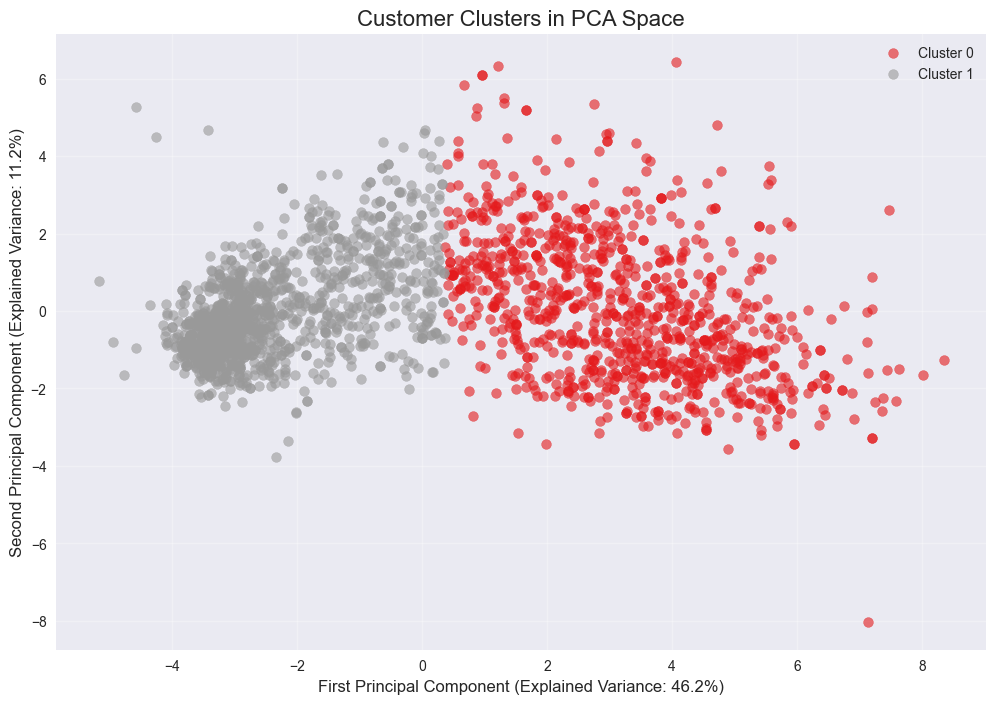

Total Explained Variance by first 2 PCs: 57.4%
PCA Components (top features by importance):

Top 5 features for PC1:
                  Feature    PC1
14         Total_MntSpent  0.309
18  Avg_Category_Spending  0.309
19     Purchase_Frequency  0.273
15        Total_Purchases  0.272
11    NumCatalogPurchases  0.264

Top 5 features for PC2:
              Feature    PC2
9   NumDealsPurchases  0.531
10    NumWebPurchases  0.341
13  NumWebVisitsMonth  0.322
2            Children  0.322
15    Total_Purchases  0.311


In [14]:
# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(scaled_df)

# Create DataFrame with PCA results
pca_df = pd.DataFrame({
    'PC1': pca_data[:, 0],
    'PC2': pca_data[:, 1],
    'Cluster': data_with_clusters[best_method]
})

# Plot PCA visualization
plt.figure(figsize=(12, 8))
colors = plt.cm.Set1(np.linspace(0, 1, optimal_k))

for i, cluster in enumerate(sorted(pca_df['Cluster'].unique())):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
               c=[colors[i]], label=f'Cluster {cluster}', alpha=0.6, s=50)

plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
plt.title('Customer Clusters in PCA Space', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total Explained Variance by first 2 PCs: {sum(pca.explained_variance_ratio_):.1%}")
print(f"PCA Components (top features by importance):")

# Get feature names from scaled_df (which doesn't have cluster columns)
original_features = scaled_df.columns.tolist()

feature_importance = pd.DataFrame({
    'Feature': original_features,
    'PC1': pca.components_[0],
    'PC2': pca.components_[1]
})
feature_importance['PC1_abs'] = abs(feature_importance['PC1'])
feature_importance['PC2_abs'] = abs(feature_importance['PC2'])

print("\nTop 5 features for PC1:")
print(feature_importance.nlargest(5, 'PC1_abs')[['Feature', 'PC1']].round(3))
print("\nTop 5 features for PC2:")
print(feature_importance.nlargest(5, 'PC2_abs')[['Feature', 'PC2']].round(3))

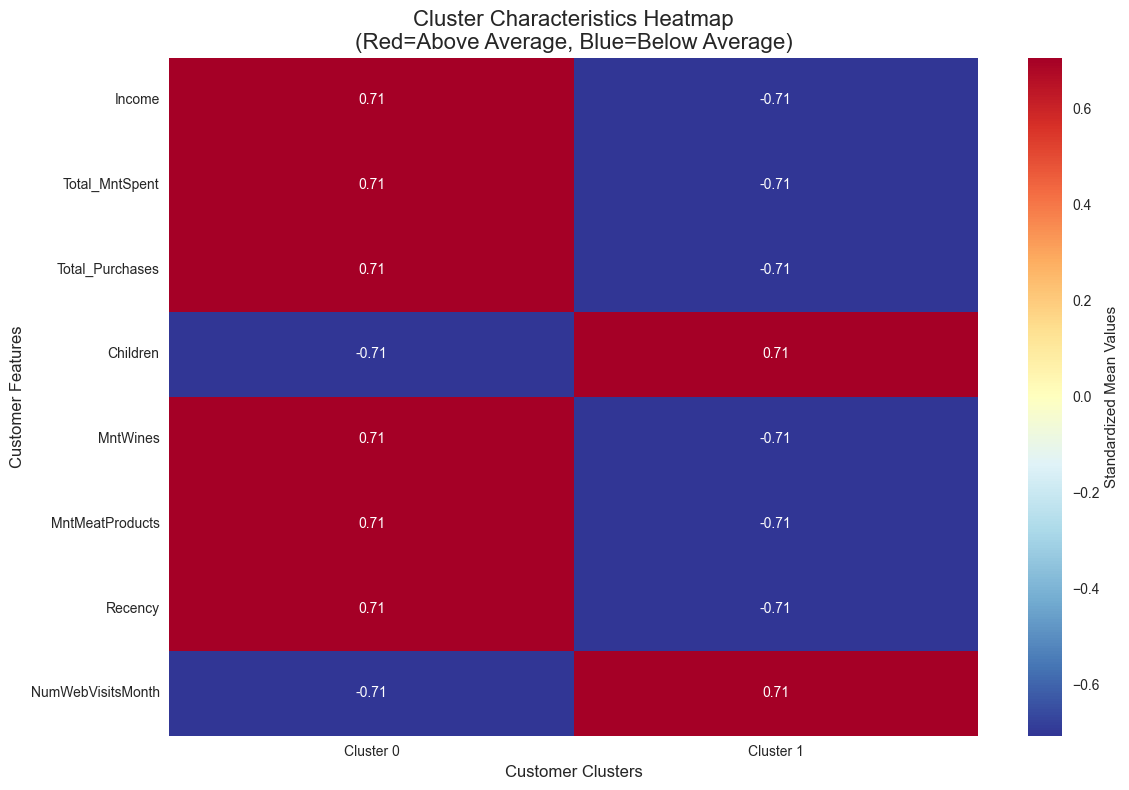

In [15]:
# Cluster comparison heatmap
# Select key metrics for heatmap
heatmap_features = available_key_features[:8]  # Top 8 features

# Calculate mean values by cluster
cluster_means = data_with_clusters.groupby(best_method)[heatmap_features].mean()

# Normalize for better visualization (z-score normalization)
cluster_means_normalized = (cluster_means - cluster_means.mean()) / cluster_means.std()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_normalized.T, 
            annot=True, 
            cmap='RdYlBu_r', 
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardized Mean Values'},
            xticklabels=[f'Cluster {i}' for i in cluster_means.index],
            yticklabels=heatmap_features)

plt.title('Cluster Characteristics Heatmap\n(Red=Above Average, Blue=Below Average)', fontsize=16)
plt.xlabel('Customer Clusters', fontsize=12)
plt.ylabel('Customer Features', fontsize=12)
plt.tight_layout()
plt.show()

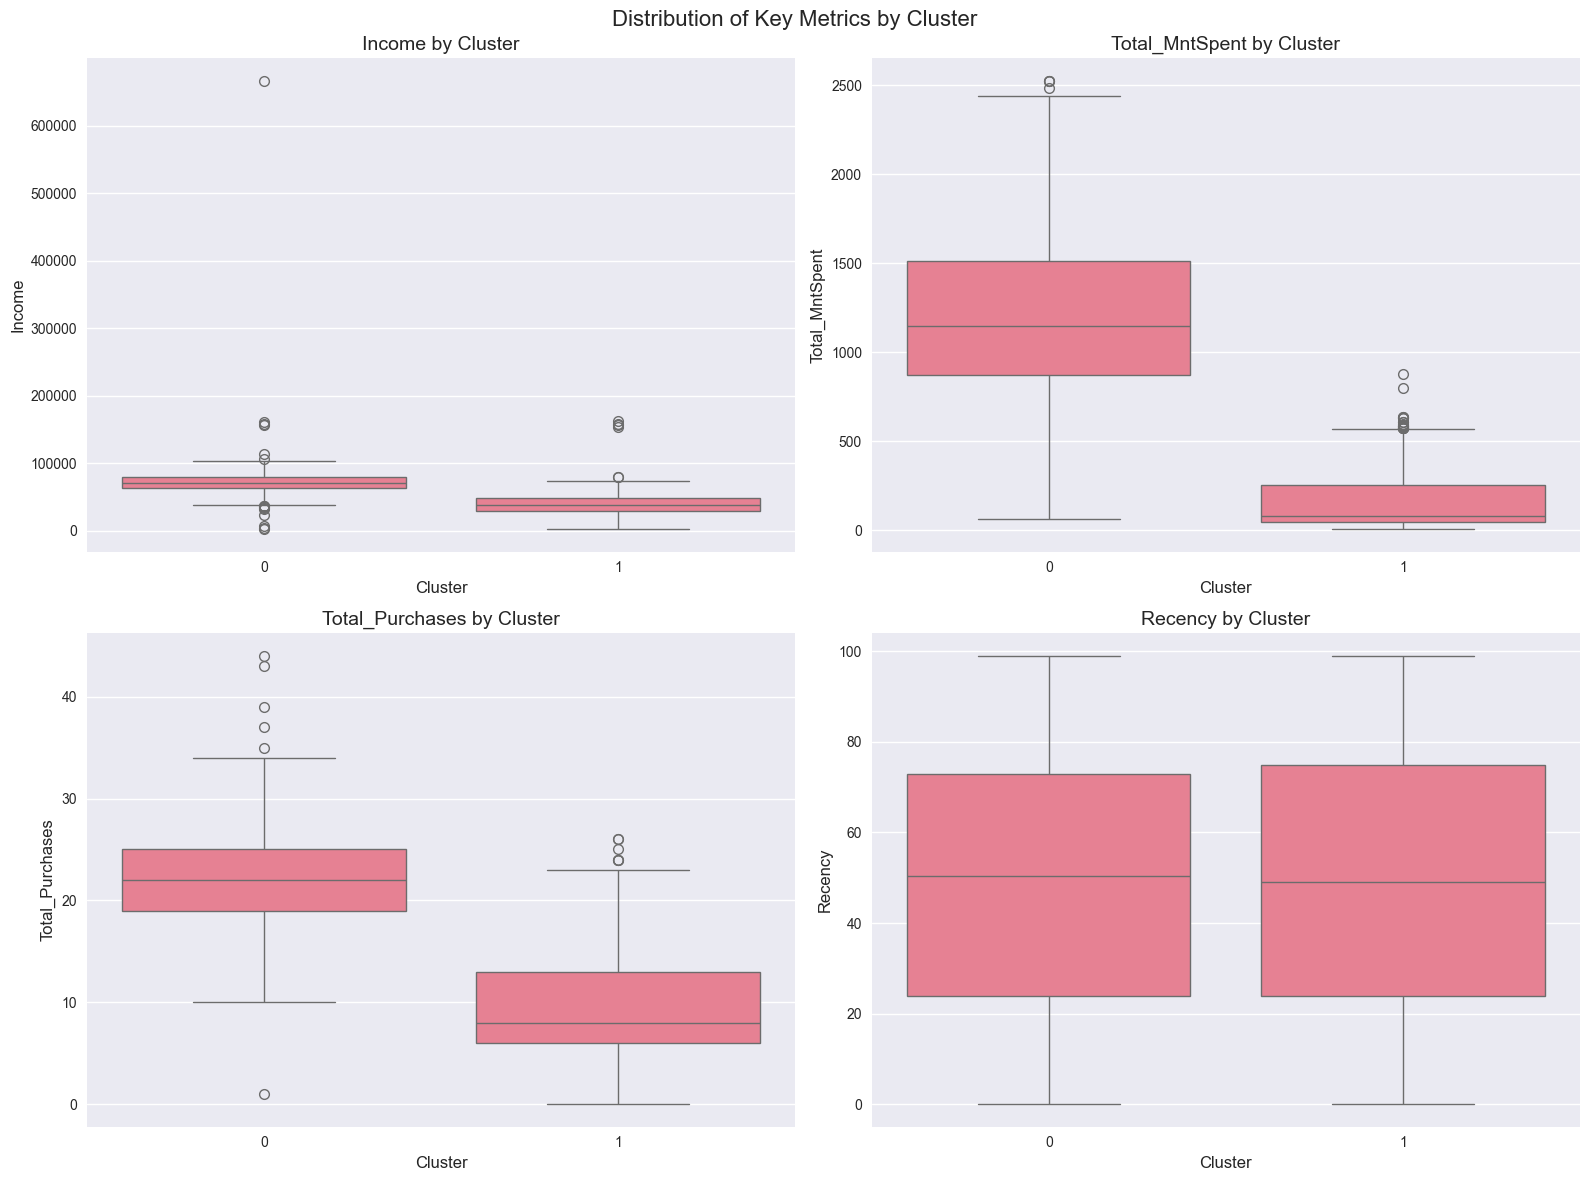

In [16]:
# Box plots for key metrics by cluster
key_metrics = ['Income', 'Total_MntSpent', 'Total_Purchases', 'Recency']
available_metrics = [col for col in key_metrics if col in data_with_clusters.columns]

if available_metrics:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    for i, metric in enumerate(available_metrics[:4]):
        if i < len(axes):
            sns.boxplot(data=data_with_clusters, x=best_method, y=metric, ax=axes[i])
            axes[i].set_title(f'{metric} by Cluster', fontsize=14)
            axes[i].set_xlabel('Cluster', fontsize=12)
            axes[i].set_ylabel(metric, fontsize=12)
    
    # Remove empty subplots
    for i in range(len(available_metrics), len(axes)):
        axes[i].remove()
    
    plt.suptitle('Distribution of Key Metrics by Cluster', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Key metrics not available for visualization.")

## Model Evaluation and Results Summary

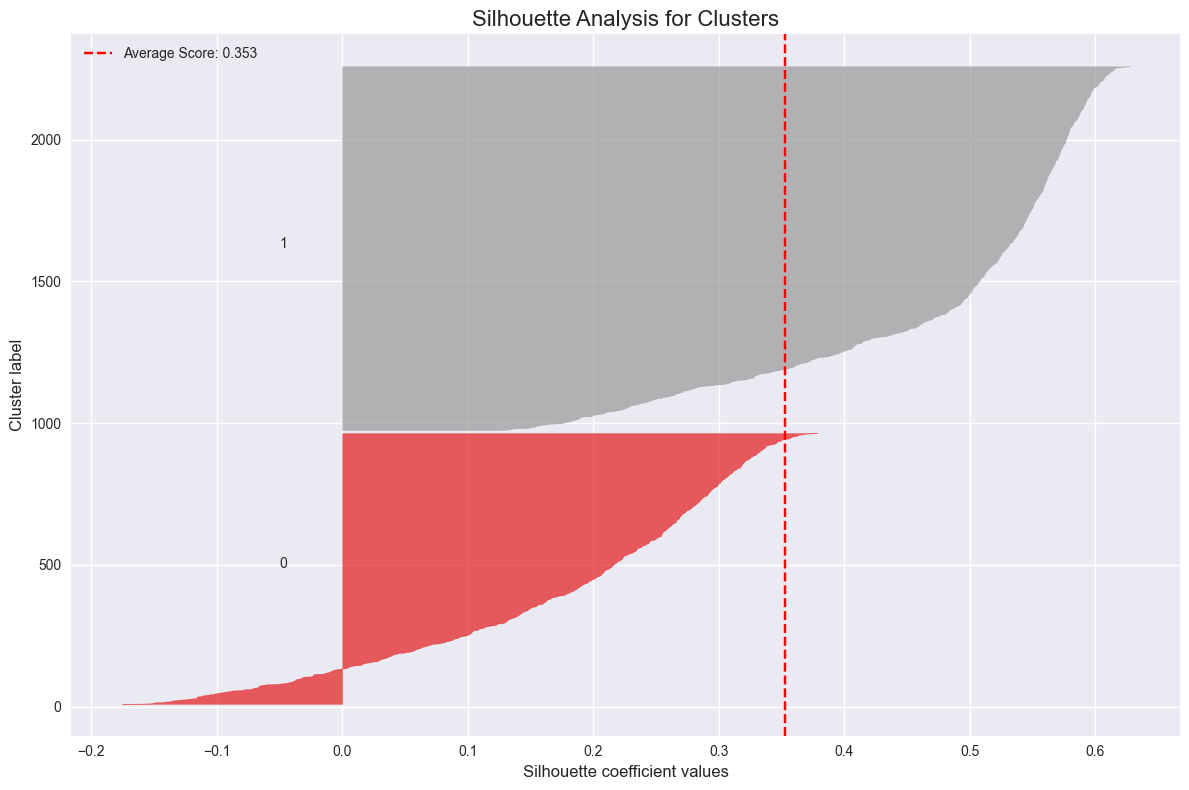


Silhouette Analysis Results:
Average Silhouette Score: 0.3526
Interpretation:
✓ Good clustering structure


In [17]:
# Detailed silhouette analysis
def plot_silhouette_analysis(data, labels, n_clusters):
    """
    Create silhouette plot for detailed cluster analysis
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calculate silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, labels)
    
    y_lower = 10
    colors = plt.cm.Set1(np.linspace(0, 1, n_clusters))
    
    for i in range(n_clusters):
        # Aggregate silhouette scores for samples in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = colors[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax.set_xlabel('Silhouette coefficient values', fontsize=12)
    ax.set_ylabel('Cluster label', fontsize=12)
    ax.set_title('Silhouette Analysis for Clusters', fontsize=16)
    
    # Add vertical line for average silhouette score
    avg_silhouette = silhouette_score(data, labels)
    ax.axvline(x=avg_silhouette, color="red", linestyle="--", 
              label=f'Average Score: {avg_silhouette:.3f}')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return avg_silhouette

# Perform silhouette analysis
best_labels = data_with_clusters[best_method].values
silhouette_avg = plot_silhouette_analysis(scaled_df, best_labels, optimal_k)

print(f"\nSilhouette Analysis Results:")
print(f"Average Silhouette Score: {silhouette_avg:.4f}")
print(f"Interpretation:")
if silhouette_avg > 0.5:
    print("✓ Excellent clustering structure")
elif silhouette_avg > 0.3:
    print("✓ Good clustering structure")
elif silhouette_avg > 0.1:
    print("⚠ Moderate clustering structure")
else:
    print("❌ Poor clustering structure")

In [18]:
# Final Results Summary
print("\n" + "="*60)
print("           CUSTOMER CLUSTERING ANALYSIS RESULTS")
print("="*60)

print(f"\n📊 Dataset Information:")
print(f"   • Total Customers: {len(data_with_clusters):,}")
print(f"   • Features Used: {len(clustering_data.columns)-2}")
print(f"   • Optimal Clusters: {optimal_k}")

print(f"\n🎯 Best Clustering Method: {best_method.replace('_', ' ')}")
print(f"   • Silhouette Score: {silhouette_avg:.4f}")
print(f"   • Quality: {'Excellent' if silhouette_avg > 0.5 else 'Good' if silhouette_avg > 0.3 else 'Moderate'}")

print(f"\n👥 Customer Segments:")
for cluster_id, persona in cluster_personas.items():
    print(f"   • Cluster {cluster_id}: {persona['size']:,} customers ({persona['percentage']:.1f}%) - {persona['spending_level']}")

print(f"\n💡 Key Insights:")
# Generate insights based on cluster analysis
total_customers = len(data_with_clusters)
high_value_clusters = [k for k, v in cluster_personas.items() if 'High' in v['spending_level']]
low_engagement_clusters = [k for k, v in cluster_personas.items() if 'Low' in v['engagement']]

if high_value_clusters:
    high_value_pct = sum([cluster_personas[c]['percentage'] for c in high_value_clusters])
    print(f"   • High-value customers represent {high_value_pct:.1f}% of the customer base")

if low_engagement_clusters:
    low_engagement_pct = sum([cluster_personas[c]['percentage'] for c in low_engagement_clusters])
    print(f"   • {low_engagement_pct:.1f}% of customers show low engagement (re-engagement needed)")

print(f"\n📈 Recommendations:")
print(f"   • Focus retention efforts on high-value segments")
print(f"   • Develop re-engagement campaigns for inactive clusters")
print(f"   • Customize marketing messages by cluster characteristics")
print(f"   • Monitor cluster migration over time")

print("\n" + "="*60)


           CUSTOMER CLUSTERING ANALYSIS RESULTS

📊 Dataset Information:
   • Total Customers: 2,240
   • Features Used: 21
   • Optimal Clusters: 2

🎯 Best Clustering Method: KMeans Cluster
   • Silhouette Score: 0.3526
   • Quality: Good

👥 Customer Segments:
   • Cluster 0: 956 customers (42.7%) - High Spender
   • Cluster 1: 1,284 customers (57.3%) - Low Spender

💡 Key Insights:
   • High-value customers represent 42.7% of the customer base

📈 Recommendations:
   • Focus retention efforts on high-value segments
   • Develop re-engagement campaigns for inactive clusters
   • Customize marketing messages by cluster characteristics
   • Monitor cluster migration over time



In [20]:
# Save results
# Save the data with cluster labels
output_file = '../data/marketing_campaign_with_clusters.csv'
data_with_clusters.to_csv(output_file, index=False)
print(f"✅ Results saved to: {output_file}")

# Save cluster profiles
cluster_profiles_summary = data_with_clusters.groupby(best_method)[available_key_features].agg(['mean', 'std', 'count']).round(2)
profiles_file = '../data/cluster_profiles.csv'
cluster_profiles_summary.to_csv(profiles_file)
print(f"✅ Cluster profiles saved to: {profiles_file}")

# Save model parameters
# Convert numpy types to native Python types for JSON serialization
unique_clusters, cluster_counts = np.unique(best_labels, return_counts=True)
cluster_distribution = {int(cluster): int(count) for cluster, count in zip(unique_clusters, cluster_counts)}

model_info = {
    'optimal_clusters': int(optimal_k),
    'best_method': best_method,
    'silhouette_score': float(silhouette_avg),
    'features_used': [str(col) for col in clustering_data.columns if col not in ['KMeans_Cluster', 'Hierarchical_Cluster']],
    'total_customers': int(len(data_with_clusters)),
    'cluster_distribution': cluster_distribution
}

import json
with open('../data/clustering_model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
    
print(f"✅ Model information saved to: ../data/clustering_model_info.json")
print(f"\n🎉 Clustering analysis complete! Check the output files for detailed results.")

✅ Results saved to: ../data/marketing_campaign_with_clusters.csv
✅ Cluster profiles saved to: ../data/cluster_profiles.csv
✅ Model information saved to: ../data/clustering_model_info.json

🎉 Clustering analysis complete! Check the output files for detailed results.
